# Data preparation

## Imports

In [53]:
%matplotlib inline

import numpy as np
import pandas as pd
import re
import nltk
from sklearn.datasets import load_files
import pickle
from itertools import product
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight


nltk.download('stopwords')
nltk.download('wordnet')
sns.set_style('whitegrid')

2.1.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data analysis

In [54]:
from google.colab import drive
drive.mount('/content/drive')

ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/ML_project/'
DATA_FILENAME = 'text_emotion.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
df = pd.read_csv(ROOT_PATH + DATA_FILENAME)
df = df.drop(columns=['tweet_id'])
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes
df.head()

,sentiment,author,content,sentiment_code
0,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,2
1,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,10
2,sadness,coolfunky,Funeral ceremony...gloomy friday...,10
3,enthusiasm,czareaquino,wants to hang out with friends SOON!,3
4,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,8


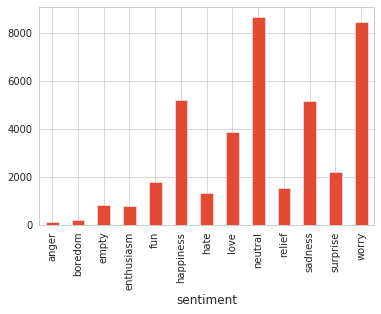

In [56]:
groups = df.groupby('sentiment').size()
groups.plot.bar()
None

In [57]:
df.groupby('author').count().max()

sentiment         23
content           23
sentiment_code    23
dtype: int64

## Cleaning

In [0]:
stemmer = WordNetLemmatizer()

def clean(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)

    text = text.lower()

    text = [stemmer.lemmatize(word) for word in text.split()]

    return ' '.join(text)

In [59]:
df['content'] = df['content'].apply(clean)
df.head()

,sentiment,author,content,sentiment_code
0,empty,xoshayzers,tiffanylue i know i wa listenin to bad habit e...,2
1,sadness,wannamama,layin n bed with a headache ughhhh waitin on y...,10
2,sadness,coolfunky,funeral ceremony gloomy friday,10
3,enthusiasm,czareaquino,want to hang out with friend soon,3
4,neutral,xkilljoyx,dannycastillo we want to trade with someone wh...,8


In [0]:
_, small_df = train_test_split(df, test_size=0.99, random_state=42)

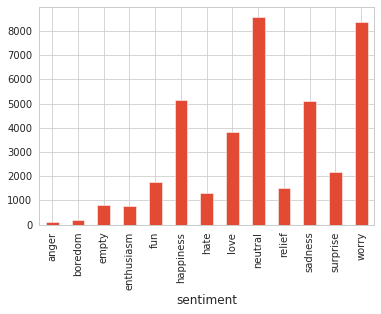

In [61]:
groups = small_df.groupby('sentiment').size()
groups.plot.bar()
None

## Vectorizing

In [62]:
all_texts = small_df['content']

tfidf_converter = TfidfVectorizer(min_df=10, max_df=0.7, stop_words=stopwords.words('english'))#, max_features=200)
tfidf_words = tfidf_converter.fit_transform(all_texts).toarray()
print(tfidf_words.shape)

bow_converter = CountVectorizer(min_df=10, max_df=0.7, stop_words=stopwords.words('english'))#, max_features=200)
bow_words = bow_converter.fit_transform(all_texts).toarray()
print(bow_words.shape)

(39600, 3093)
(39600, 3093)


In [0]:
# tfidf_converter.vocabulary_

In [64]:
unq, count = np.unique(bow_words, axis=0, return_counts=True)
sum(count>1)

757

In [0]:
# X_train, X_test, y_train, y_test
splited = {
    'tfidf': train_test_split(tfidf_words, small_df['sentiment_code'], test_size=0.2, random_state=13),
    'bow': train_test_split(bow_words, small_df['sentiment_code'], test_size=0.2, random_state=13)
}

# Models

## Baseline

In [0]:
def check_model_on_data(X_train, X_test, y_train, y_test):
    def aux(model):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = (preds == y_test).mean()
        return preds, acc
        
    return aux

check_model_tfidf = check_model_on_data(*splited['tfidf'])
check_model_bow = check_model_on_data(*splited['bow'])

In [0]:
def check_acc(model):
    start = time.time()
    _, acc = check_model_tfidf(model)
    elapsed = time.time() - start
    print(f'Accouracy on TFIDF representation: {acc}')
    print(f'It took {elapsed}')

    start = time.time()
    _, acc = check_model_bow(model)
    elapsed = time.time() - start
    print(f'Accouracy on BOW representation: {acc}')
    print(f'It took {elapsed}')



In [0]:
class DummyModel():
    def __init__(self, target):
        self.target = target

    def fit(self, X, y):
        pass

    def predict(self, X):
        return self.target * np.ones((len(X),))

model = DummyModel(8)
check_acc(model)

Accouracy on TFIDF representation: 0.21691919191919193
It took 0.0008749961853027344
Accouracy on BOW representation: 0.21691919191919193
It took 0.0009515285491943359


In [0]:
model = MultinomialNB()
check_acc(model)

Accouracy on TFIDF representation: 0.31287878787878787
It took 0.433002233505249
Accouracy on BOW representation: 0.3215909090909091
It took 9.91157865524292


In [0]:
model = LinearSVC()
check_acc(model)

Accouracy on TFIDF representation: 0.32891414141414144
It took 1.953326940536499
Accouracy on BOW representation: 0.3183080808080808
It took 17.721759796142578


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
model = RandomForestClassifier(n_estimators=10)
check_acc(model)

Accouracy on TFIDF representation: 0.3047979797979798
It took 23.671847105026245
Accouracy on BOW representation: 0.2957070707070707
It took 20.011266708374023


In [70]:
model = LogisticRegression(max_iter=1000)
check_acc(model)

Accouracy on TFIDF representation: 0.34444444444444444
It took 74.30105686187744
Accouracy on BOW representation: 0.3333333333333333
It took 79.85781478881836


## Make it better

In [0]:
def tuneParam(Model, param_to_tune, tune_iterable, n_iters=5, model_params={}):
    res = []
    X = tfidf_words
    Y = np.array(small_df['sentiment_code'])

    for rep in range(n_iters):
        print(rep, end=' ')
        size = len(X)
        bootstrap_sel = np.random.choice(size, size)
        all_idxs = np.arange(size)
        test_sel = np.delete(all_idxs, bootstrap_sel)

        bootstrapX = X[bootstrap_sel]
        bootstrapY = Y[bootstrap_sel]
        
        testX = X[test_sel]
        testY = Y[test_sel]


        for param in tune_iterable:
            print('.', end='')

            model_params[param_to_tune] = param

            # print(model_params)

            model = Model(**model_params)
            model.fit(bootstrapX, bootstrapY)
            train_acc = (model.predict(bootstrapX) == bootstrapY).mean()
            test_acc = (model.predict(testX) == testY).mean()
            
            res.append({
                param_to_tune: param, 
                'err': 1-test_acc, 
                'subset': 'test'
                })
            res.append({
                param_to_tune: param, 
                'err': 1-train_acc, 
                'subset': 'train'
                })

        print('')

    lowest_error = 1
    best_value = None
    for result in res:
        if result['subset'] == 'train':
            continue
        if result['err'] < lowest_error:
            lowest_error = result['err']
            best_value = result[param_to_tune]

    res = pd.DataFrame(res)
    print(f'Best value error is {lowest_error} for {param_to_tune} = {best_value}')
    chart = sns.catplot(kind='box', x=param_to_tune, y='err', col='subset', color='blue', data=res)
    chart.set_xticklabels(rotation=45)

### MultinomialNB

0 ..........
1 ..........
2 ..........
3 ..........
4 ..........


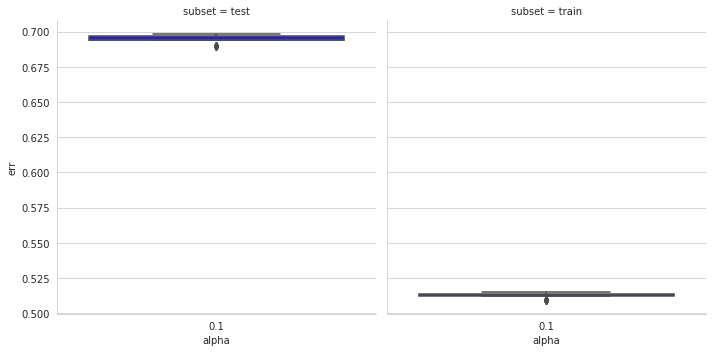

In [0]:
tuneParam(MultinomialNB, 'alpha', [1/10 for x in range(10)])

### LinearSVC

0 .....
1 .....
2 .....
3 .....
4 .....


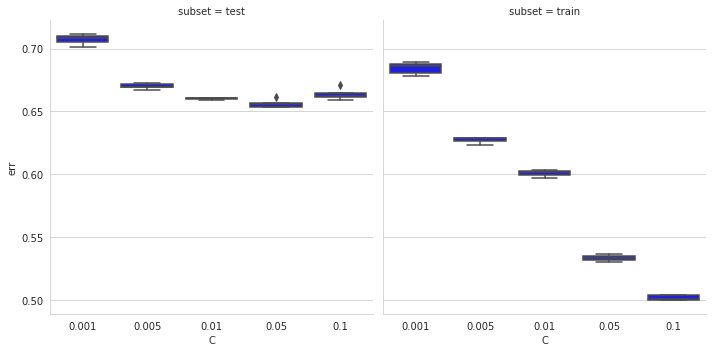

In [0]:
tuneParam(LinearSVC, 'C', [0.001, 0.005, 0.01, 0.05, 0.1], n_iters=5)

In [0]:
model = LinearSVC(C=0.05)
check_acc(model)

Accouracy on TFIDF representation: 0.351010101010101
It took 1.0875043869018555
Accouracy on BOW representation: 0.35025252525252526
It took 2.4554450511932373


### RandomForestClassifier

0 .....
1 .....
2 .....
3 .....
4 .....
Best value error is 0.7122124863088719 for max_depth = 51


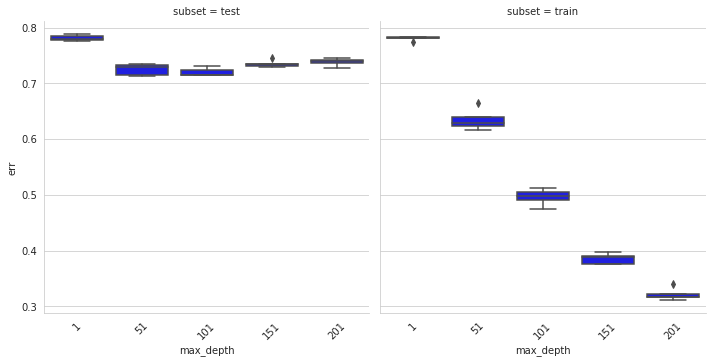

In [0]:
tuneParam(RandomForestClassifier, 'max_depth', range(1, 202, 50), model_params=dict(n_estimators=1))

0 ..........
1 ..........
2 ..........
3 ..........
4 ..........
Best value error is 0.6843477664173472 for min_samples_split = 1402


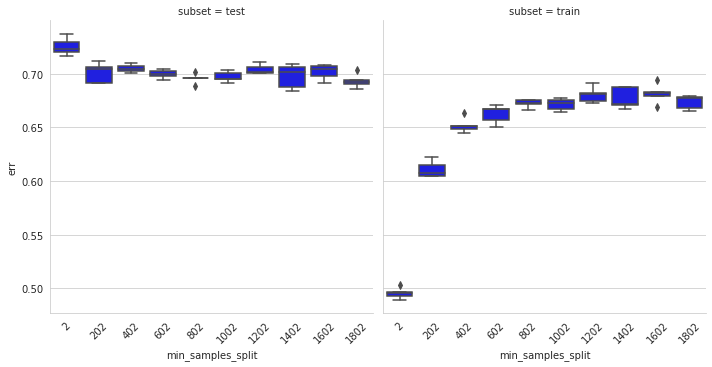

In [0]:
tuneParam(RandomForestClassifier, 'min_samples_split', range(2, 2000, 200), model_params=dict(n_estimators=1, n_jobs=-1, max_depth=100))

In [0]:
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=100, min_samples_split=800)
check_acc(model)

Accouracy on TFIDF representation: 0.3498737373737374
It took 63.69329047203064
Accouracy on BOW representation: 0.35593434343434344
It took 60.88403582572937


### LogisticRegression

0 ....
1 ....
2 ....
3 ....
4 ....
Best value error is 0.6598222283469992 for C = 0.25


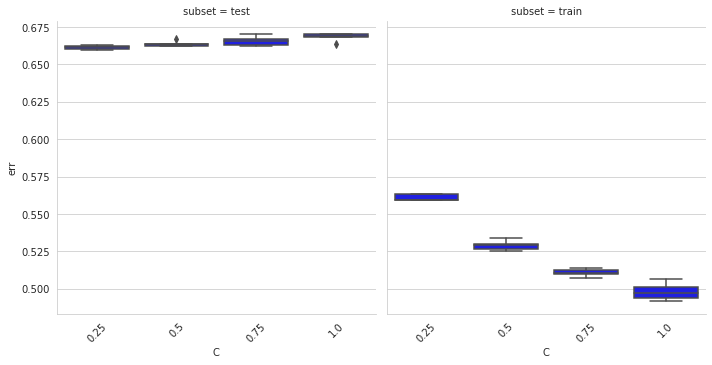

In [0]:
tuneParam(LogisticRegression, 'C', [0.25, 0.5, 0.75, 1], model_params=dict(n_jobs=-1))

In [0]:
model = LogisticRegression(n_jobs=-1, C=0.25)
check_acc(model)

Accouracy on TFIDF representation: 0.34305555555555556
It took 86.5691614151001
Accouracy on BOW representation: 0.3486111111111111
It took 87.3418824672699


## Try NN

In [0]:
# from https://realpython.com/python-keras-text-classification/
# changed to fit current API
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [0]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = splited['tfidf']
y_train_exp = np.array(y_train_exp)
y_test_exp = np.array(y_test_exp)
X_train_exp.shape

(31680, 3093)

### Baseline

#### Tiny model

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[X_train_exp.shape[1]]),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(13, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
tiny_history = model.fit(X_train_exp, y_train_exp, validation_data=(X_test_exp, y_test_exp), epochs=10)

Train on 31680 samples, validate on 7920 samples
Epoch 1/10
31680/31680 [==============================] - 4s 116us/sample - loss: 2.2469 - accuracy: 0.2213 - val_loss: 2.0946 - val_accuracy: 0.2659
Epoch 2/10
31680/31680 [==============================] - 3s 104us/sample - loss: 2.0376 - accuracy: 0.3103 - val_loss: 2.0055 - val_accuracy: 0.3088
Epoch 3/10
31680/31680 [==============================] - 3s 103us/sample - loss: 1.9422 - accuracy: 0.3468 - val_loss: 1.9609 - val_accuracy: 0.3235
Epoch 4/10
31680/31680 [==============================] - 3s 104us/sample - loss: 1.8825 - accuracy: 0.3680 - val_loss: 1.9431 - val_accuracy: 0.3299
Epoch 5/10
31680/31680 [==============================] - 3s 105us/sample - loss: 1.8436 - accuracy: 0.3817 - val_loss: 1.9372 - val_accuracy: 0.3330
Epoch 6/10
31680/31680 [==============================] - 3s 105us/sample - loss: 1.8159 - accuracy: 0.3917 - val_loss: 1.9381 - val_accuracy: 0.3336
Epoch 7/10
31680/31680 [===========================

The best accuracy was 0.3336

#### Big model

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=[X_train_exp.shape[1]]),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(13, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
big_history = model.fit(X_train_exp, y_train_exp, validation_data=(X_test_exp, y_test_exp), epochs=10)

Train on 31680 samples, validate on 7920 samples
Epoch 1/10
31680/31680 [==============================] - 4s 114us/sample - loss: 1.7433 - accuracy: 0.4136 - val_loss: 1.9691 - val_accuracy: 0.3297
Epoch 2/10
31680/31680 [==============================] - 3s 105us/sample - loss: 1.7350 - accuracy: 0.4151 - val_loss: 1.9761 - val_accuracy: 0.3304
Epoch 3/10
31680/31680 [==============================] - 3s 104us/sample - loss: 1.7280 - accuracy: 0.4179 - val_loss: 1.9826 - val_accuracy: 0.3273
Epoch 4/10
31680/31680 [==============================] - 3s 106us/sample - loss: 1.7214 - accuracy: 0.4187 - val_loss: 1.9900 - val_accuracy: 0.3277
Epoch 5/10
31680/31680 [==============================] - 3s 105us/sample - loss: 1.7155 - accuracy: 0.4218 - val_loss: 1.9961 - val_accuracy: 0.3285
Epoch 6/10
31680/31680 [==============================] - 3s 105us/sample - loss: 1.7104 - accuracy: 0.4226 - val_loss: 2.0029 - val_accuracy: 0.3275
Epoch 7/10
31680/31680 [===========================

The best accuracy on big model: 0.3304


### Overfitting analysis

Those are plots of performance of both models during 10 epochs. As one can see, the loss of tiny model reach minimum at epoch ~5, where loss of big model is only getting bigger. It says that it overfits much faster.

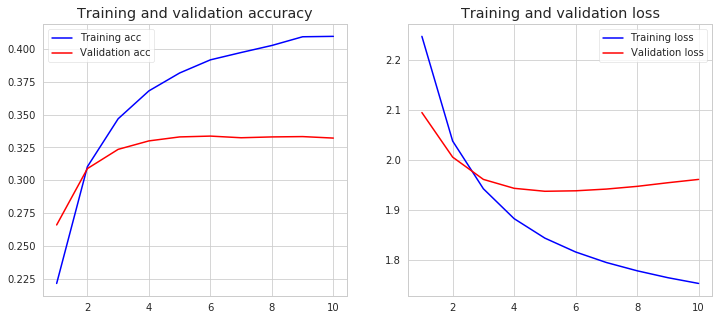

In [0]:
plot_history(tiny_history)

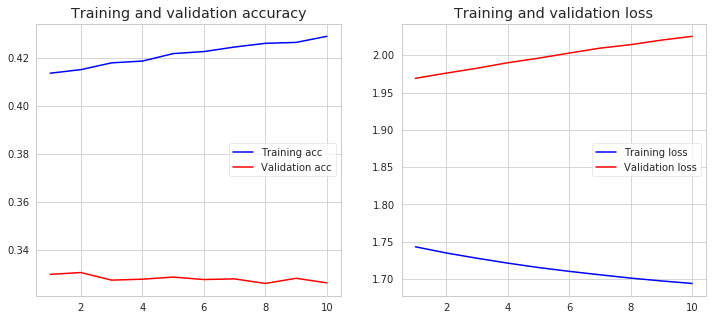

In [0]:
plot_history(big_history)

### Make it better

#### Dropout

To make process of overfitting slower and (hopefully) get better accuracy we will introduce `Dropout` layer in both of our baseline models. It will set fraction of its inputs to 0 at random. Mentioned fraction is the parameter of a layer

In [0]:
def make_model_with_dropout(dense_neurons, dropout_ratio, verbose=False):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=[X_train_exp.shape[1]]))
    model.add(keras.layers.Dropout(dropout_ratio))
    model.add(keras.layers.Dense(dense_neurons, activation='relu'))
    model.add(keras.layers.Dense(13, activation='softmax'))


    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    if verbose:
        model.summary()

    return model

In [0]:
model = make_model_with_dropout(4, 0.2)
history = model.fit(X_train_exp, y_train_exp, validation_data=(X_test_exp, y_test_exp), epochs=20)

Train on 31680 samples, validate on 7920 samples
Epoch 1/20
31680/31680 [==============================] - 4s 120us/sample - loss: 2.2503 - accuracy: 0.2260 - val_loss: 2.1141 - val_accuracy: 0.2557
Epoch 2/20
31680/31680 [==============================] - 3s 109us/sample - loss: 2.0632 - accuracy: 0.2908 - val_loss: 2.0320 - val_accuracy: 0.3029
Epoch 3/20
31680/31680 [==============================] - 3s 108us/sample - loss: 1.9908 - accuracy: 0.3268 - val_loss: 1.9901 - val_accuracy: 0.3100
Epoch 4/20
31680/31680 [==============================] - 3s 109us/sample - loss: 1.9462 - accuracy: 0.3363 - val_loss: 1.9667 - val_accuracy: 0.3197
Epoch 5/20
31680/31680 [==============================] - 3s 109us/sample - loss: 1.9141 - accuracy: 0.3464 - val_loss: 1.9516 - val_accuracy: 0.3223
Epoch 6/20
31680/31680 [==============================] - 3s 109us/sample - loss: 1.8863 - accuracy: 0.3538 - val_loss: 1.9421 - val_accuracy: 0.3236
Epoch 7/20
31680/31680 [===========================

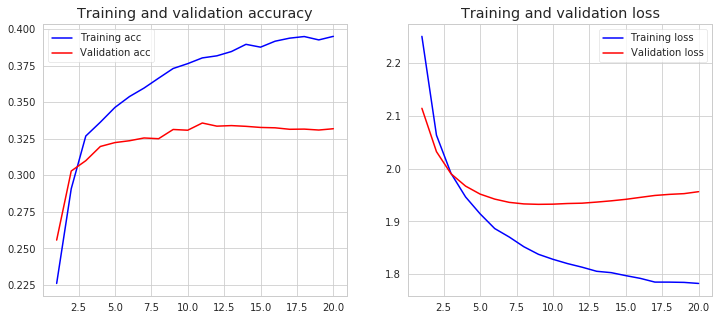

In [0]:
plot_history(history)

In [0]:
model = make_model_with_dropout(512, 0.2)
history = model.fit(X_train_exp, y_train_exp, validation_data=(X_test_exp, y_test_exp), epochs=10)

Train on 31680 samples, validate on 7920 samples
Epoch 1/10
31680/31680 [==============================] - 4s 118us/sample - loss: 2.0122 - accuracy: 0.3020 - val_loss: 1.9003 - val_accuracy: 0.3438
Epoch 2/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.8147 - accuracy: 0.3712 - val_loss: 1.9061 - val_accuracy: 0.3369
Epoch 3/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.7049 - accuracy: 0.4032 - val_loss: 1.9371 - val_accuracy: 0.3323
Epoch 4/10
31680/31680 [==============================] - 3s 108us/sample - loss: 1.6029 - accuracy: 0.4363 - val_loss: 1.9914 - val_accuracy: 0.3258
Epoch 5/10
31680/31680 [==============================] - 3s 108us/sample - loss: 1.5028 - accuracy: 0.4726 - val_loss: 2.0382 - val_accuracy: 0.3203
Epoch 6/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.4000 - accuracy: 0.5123 - val_loss: 2.0943 - val_accuracy: 0.3196
Epoch 7/10
31680/31680 [===========================

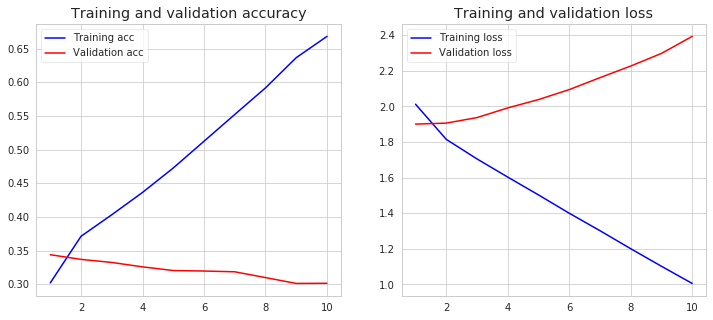

In [0]:
plot_history(history)

In [0]:
model = make_model_with_dropout(512, 0.5)
history = model.fit(X_train_exp, y_train_exp, validation_data=(X_test_exp, y_test_exp), epochs=10)

Train on 31680 samples, validate on 7920 samples
Epoch 1/10
31680/31680 [==============================] - 4s 133us/sample - loss: 2.0753 - accuracy: 0.2759 - val_loss: 1.9566 - val_accuracy: 0.3275
Epoch 2/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.9481 - accuracy: 0.3239 - val_loss: 1.9281 - val_accuracy: 0.3361
Epoch 3/10
31680/31680 [==============================] - 3s 108us/sample - loss: 1.8911 - accuracy: 0.3380 - val_loss: 1.9283 - val_accuracy: 0.3351
Epoch 4/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.8562 - accuracy: 0.3486 - val_loss: 1.9335 - val_accuracy: 0.3383
Epoch 5/10
31680/31680 [==============================] - 3s 109us/sample - loss: 1.8230 - accuracy: 0.3572 - val_loss: 1.9424 - val_accuracy: 0.3351
Epoch 6/10
31680/31680 [==============================] - 3s 110us/sample - loss: 1.7902 - accuracy: 0.3685 - val_loss: 1.9498 - val_accuracy: 0.3352
Epoch 7/10
31680/31680 [===========================

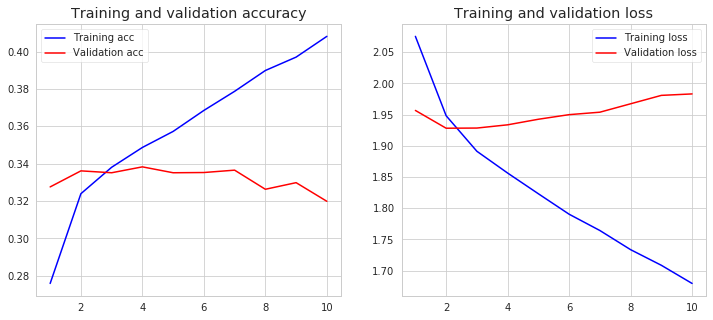

In [0]:
plot_history(history)

#### Word Embeddings


Now we will embed words into space where simmilar words are close to each other. First, we will learn embedding ourselve and then we will use pretrained one.

In [0]:
# creating embedding ourselve
sentences_train, sentences_test, y_train, y_test = train_test_split(small_df['content'], small_df['sentiment_code'], test_size=0.2, random_state=13)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
# strategy = tf.distribute.MirroredStrategy()
embedding_dim = 50

def make_model_with_embedding(dense_neurons, verbose=False):
    with strategy.scope():

        model = keras.Sequential()
        model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                output_dim=embedding_dim, 
                                input_length=maxlen,
                                trainable=True))
        model.add(keras.layers.GlobalMaxPool1D())
        model.add(keras.layers.Dense(dense_neurons, activation='relu'))
        model.add(keras.layers.Dense(13, activation='softmax'))

        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        
        if verbose:
            model.summary()

        return model

In [0]:
model = make_model_with_embedding(4)
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 3s 96us/sample - loss: 2.5393 - accuracy: 0.1790 - val_loss: 2.5012 - val_accuracy: 0.2087
Epoch 2/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.4598 - accuracy: 0.2067 - val_loss: 2.4098 - val_accuracy: 0.2087
Epoch 3/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.3603 - accuracy: 0.2171 - val_loss: 2.3062 - val_accuracy: 0.2379
Epoch 4/30
31680/31680 [==============================] - 0s 12us/sample - loss: 2.2601 - accuracy: 0.2385 - val_loss: 2.2173 - val_accuracy: 0.2307
Epoch 5/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.1799 - accuracy: 0.2488 - val_loss: 2.1540 - val_accuracy: 0.2595
Epoch 6/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.1193 - accuracy: 0.2878 - val_loss: 2.1085 - val_accuracy: 0.2795
Epoch 7/30
31680/31680 [==============================] -

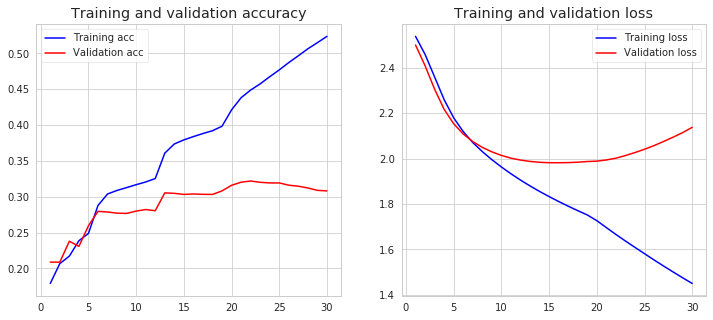

In [0]:
plot_history(history)

In [0]:
model = make_model_with_embedding(512)
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 4s 127us/sample - loss: 2.3265 - accuracy: 0.2047 - val_loss: 2.1709 - val_accuracy: 0.2316
Epoch 2/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.1526 - accuracy: 0.2441 - val_loss: 2.1363 - val_accuracy: 0.2607
Epoch 3/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.1287 - accuracy: 0.2741 - val_loss: 2.1148 - val_accuracy: 0.2722
Epoch 4/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.0855 - accuracy: 0.2882 - val_loss: 2.0613 - val_accuracy: 0.2811
Epoch 5/30
31680/31680 [==============================] - 0s 11us/sample - loss: 2.0048 - accuracy: 0.3077 - val_loss: 1.9940 - val_accuracy: 0.3062
Epoch 6/30
31680/31680 [==============================] - 0s 11us/sample - loss: 1.9135 - accuracy: 0.3505 - val_loss: 1.9430 - val_accuracy: 0.3367
Epoch 7/30
31680/31680 [==============================] 

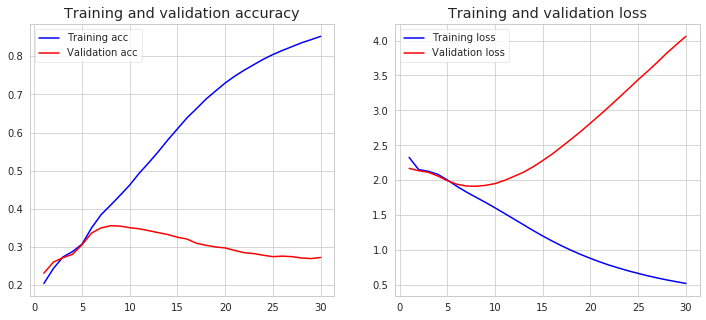

In [0]:
plot_history(history)

Now, lets use pretrained embedding. We will use `glove.6B` and `glove.twitter.27B`. One can find them online
- [glove6B](http://nlp.stanford.edu/data/glove.6B.zip) (~800MB)
- [glove.twitter.27B](http://nlp.stanford.edu/data/glove.twitter.27B.zip) (~1.4GB)


In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip
# !cp glove.6B.50d.txt 'drive/My Drive/Colab Notebooks/ML_project/'
# !cp glove.6B.300d.txt 'drive/My Drive/Colab Notebooks/ML_project/'

--2020-01-25 23:27:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-01-25 23:27:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-01-25 23:27:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
external_embeddings = {
    '6B.300d': create_embedding_matrix(
        f'{ROOT_PATH}glove.6B.300d.txt',
        tokenizer.word_index, 
        300
    ),
    'twitter.27B.200d': create_embedding_matrix(
        f'{ROOT_PATH}glove.twitter.27B.200d.txt',
        tokenizer.word_index, 
        200
    ),
}

In [0]:
def check_coverage(name):
    embedding_matrix = external_embeddings[name]

    nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))

    return nonzero_elements / vocab_size


In [0]:
check_coverage('6B.300d')

0.47299741602067186

In [0]:
check_coverage('twitter.27B.200d')

0.5272868217054264

In [0]:
def make_model_with_external_embedding(dense_neurons, name, verbose=False):
    with strategy.scope():

        embedding_dim = int(name.split('.')[-1][:-1]) # take last part of name withoud 'd' as int
        embedding_matrix = external_embeddings[name]

        model = keras.Sequential()
        model.add(keras.layers.Embedding(vocab_size, embedding_dim, 
                                weights=[embedding_matrix], 
                                input_length=maxlen, 
                                trainable=True))
        model.add(keras.layers.GlobalMaxPool1D())
        model.add(keras.layers.Dense(dense_neurons, activation='relu'))
        model.add(keras.layers.Dense(13, activation='softmax'))
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        
        if verbose:
            model.summary()

        return model


In [0]:
model = make_model_with_external_embedding(4, '6B.300d')
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 1s 42us/sample - loss: 2.5567 - accuracy: 0.1946 - val_loss: 2.5377 - val_accuracy: 0.2159
Epoch 2/30
31680/31680 [==============================] - 1s 21us/sample - loss: 2.5163 - accuracy: 0.2157 - val_loss: 2.4884 - val_accuracy: 0.2168
Epoch 3/30
31680/31680 [==============================] - 1s 21us/sample - loss: 2.4494 - accuracy: 0.2162 - val_loss: 2.4145 - val_accuracy: 0.2169
Epoch 4/30
31680/31680 [==============================] - 1s 20us/sample - loss: 2.3715 - accuracy: 0.2160 - val_loss: 2.3427 - val_accuracy: 0.2169
Epoch 5/30
31680/31680 [==============================] - 1s 21us/sample - loss: 2.3032 - accuracy: 0.2159 - val_loss: 2.2829 - val_accuracy: 0.2169
Epoch 6/30
31680/31680 [==============================] - 1s 21us/sample - loss: 2.2451 - accuracy: 0.2172 - val_loss: 2.2310 - val_accuracy: 0.2236
Epoch 7/30
31680/31680 [==============================] -

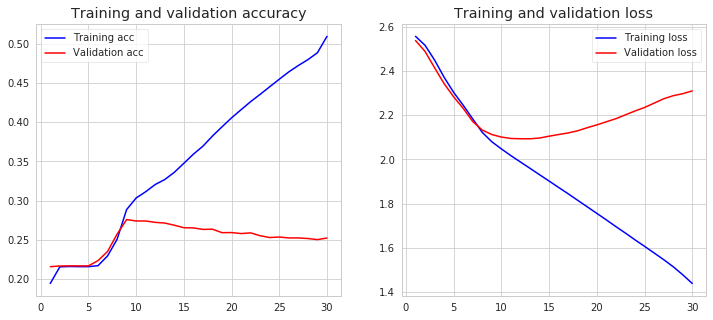

In [0]:
plot_history(history)

In [0]:
model = make_model_with_external_embedding(4, 'twitter.27B.200d')
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 2s 71us/sample - loss: 2.4915 - accuracy: 0.1983 - val_loss: 2.4284 - val_accuracy: 0.2109
Epoch 2/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.3967 - accuracy: 0.2126 - val_loss: 2.3614 - val_accuracy: 0.2117
Epoch 3/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.3311 - accuracy: 0.2237 - val_loss: 2.2958 - val_accuracy: 0.2319
Epoch 4/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.2613 - accuracy: 0.2441 - val_loss: 2.2367 - val_accuracy: 0.2409
Epoch 5/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.2043 - accuracy: 0.2651 - val_loss: 2.1942 - val_accuracy: 0.2549
Epoch 6/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.1610 - accuracy: 0.2806 - val_loss: 2.1632 - val_accuracy: 0.2615
Epoch 7/30
31680/31680 [==============================] -

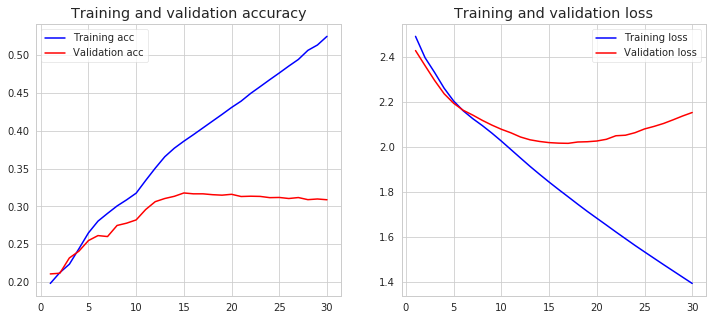

In [0]:
plot_history(history)

In [0]:
model = make_model_with_external_embedding(512, '6B.300d')
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 2s 57us/sample - loss: 2.1681 - accuracy: 0.2415 - val_loss: 2.0964 - val_accuracy: 0.2777
Epoch 2/30
31680/31680 [==============================] - 1s 21us/sample - loss: 2.0535 - accuracy: 0.2980 - val_loss: 2.0259 - val_accuracy: 0.3061
Epoch 3/30
31680/31680 [==============================] - 1s 22us/sample - loss: 1.9669 - accuracy: 0.3350 - val_loss: 1.9814 - val_accuracy: 0.3232
Epoch 4/30
31680/31680 [==============================] - 1s 21us/sample - loss: 1.8938 - accuracy: 0.3584 - val_loss: 1.9434 - val_accuracy: 0.3391
Epoch 5/30
31680/31680 [==============================] - 1s 21us/sample - loss: 1.8273 - accuracy: 0.3842 - val_loss: 1.9294 - val_accuracy: 0.3436
Epoch 6/30
31680/31680 [==============================] - 1s 21us/sample - loss: 1.7690 - accuracy: 0.4018 - val_loss: 1.9151 - val_accuracy: 0.3482
Epoch 7/30
31680/31680 [==============================] -

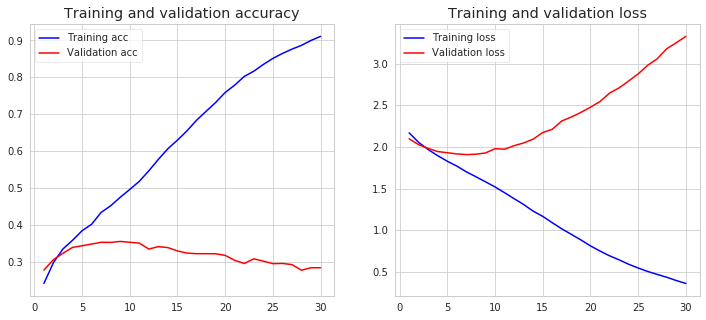

In [0]:
plot_history(history)

In [0]:
model = make_model_with_external_embedding(512, 'twitter.27B.200d')
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/30
31680/31680 [==============================] - 2s 70us/sample - loss: 2.1559 - accuracy: 0.2513 - val_loss: 2.0831 - val_accuracy: 0.2763
Epoch 2/30
31680/31680 [==============================] - 1s 17us/sample - loss: 2.0248 - accuracy: 0.3053 - val_loss: 2.0006 - val_accuracy: 0.3155
Epoch 3/30
31680/31680 [==============================] - 1s 17us/sample - loss: 1.9401 - accuracy: 0.3412 - val_loss: 1.9511 - val_accuracy: 0.3318
Epoch 4/30
31680/31680 [==============================] - 1s 17us/sample - loss: 1.8823 - accuracy: 0.3642 - val_loss: 1.9310 - val_accuracy: 0.3429
Epoch 5/30
31680/31680 [==============================] - 1s 18us/sample - loss: 1.8309 - accuracy: 0.3789 - val_loss: 1.9204 - val_accuracy: 0.3407
Epoch 6/30
31680/31680 [==============================] - 1s 17us/sample - loss: 1.7836 - accuracy: 0.3958 - val_loss: 1.8989 - val_accuracy: 0.3504
Epoch 7/30
31680/31680 [==============================] -

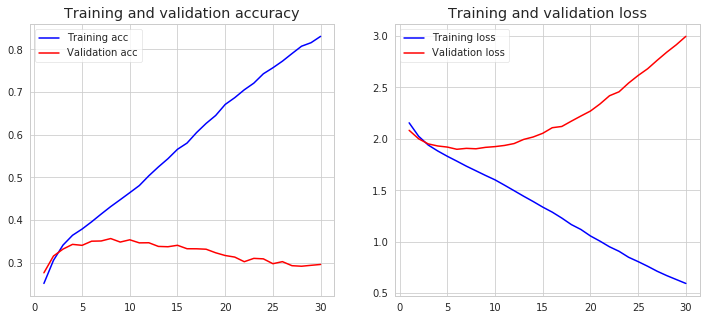

In [0]:
plot_history(history)

#### Convolutional NN (CNN)


Next idea to test is `Convolutional` layer that are said to works well for identifying simple patterns

In [0]:
def make_model_with_conv(dense_neurons, name, verbose=False):
    with strategy.scope():

        embedding_dim = int(name.split('.')[-1][:-1]) # take last part of name withoud 'd' as int
        embedding_matrix = external_embeddings[name]

        model = keras.Sequential()
        model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix]))
        model.add(keras.layers.Conv1D(100, 10, activation='relu'))
        model.add(keras.layers.GlobalAveragePooling1D())
        model.add(keras.layers.Dense(dense_neurons, activation='relu'))
        model.add(keras.layers.Dense(13, activation='softmax'))
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        if verbose:
            model.summary()

        return model

In [0]:
model = make_model_with_conv(4, 'twitter.27B.200d')
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    batch_size=1000)

Train on 31680 samples, validate on 7920 samples
Epoch 1/20
31680/31680 [==============================] - 3s 88us/sample - loss: 2.5336 - accuracy: 0.0833 - val_loss: 2.4935 - val_accuracy: 0.1124
Epoch 2/20
31680/31680 [==============================] - 1s 32us/sample - loss: 2.4561 - accuracy: 0.1683 - val_loss: 2.4014 - val_accuracy: 0.2192
Epoch 3/20
31680/31680 [==============================] - 1s 32us/sample - loss: 2.3590 - accuracy: 0.2202 - val_loss: 2.3088 - val_accuracy: 0.2197
Epoch 4/20
31680/31680 [==============================] - 1s 33us/sample - loss: 2.2673 - accuracy: 0.2295 - val_loss: 2.2339 - val_accuracy: 0.2230
Epoch 5/20
31680/31680 [==============================] - 1s 32us/sample - loss: 2.1906 - accuracy: 0.2342 - val_loss: 2.1771 - val_accuracy: 0.2250
Epoch 6/20
31680/31680 [==============================] - 1s 33us/sample - loss: 2.1238 - accuracy: 0.2429 - val_loss: 2.1391 - val_accuracy: 0.2288
Epoch 7/20
31680/31680 [==============================] -

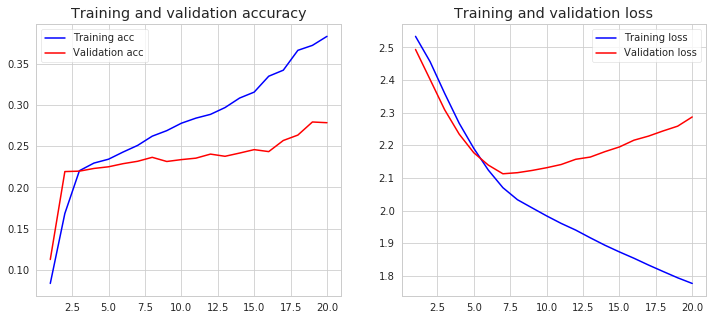

In [0]:
plot_history(history)

In [0]:
model = make_model_with_conv(512, 'twitter.27B.200d')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    batch_size=1000,
                    callbacks=[early_stop])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 31680 samples, validate on 7920 samples
Epoch 1/20
31680/31680 [==============================] - 9s 296us/sample - loss: 2.2543 - accuracy: 0.2437 - val_loss: 2.1214 - val_accuracy: 0.2524
Epoch 2/20
31680/31680 [==============================] - 1s 33us/sample - loss: 2.0797 - accuracy: 0.2777 - val_loss: 2.0340 - val_accuracy: 0.2976
Epoch 3/20
31680/31680 [==============================] - 1s 33us/sample - loss: 1.9812 - accuracy: 0.3222 - val_loss: 1.9685 - val_accuracy: 0.3221
Epoch 4/20
31680/31680 [==============================] - 1s 34us/sample - loss: 1.9148 - accuracy: 0.3501 - val_loss: 1.9329 - val_accuracy: 0.3388
Epoch 5/20
31680/31680 [==============================] - 1s 33us/sample -

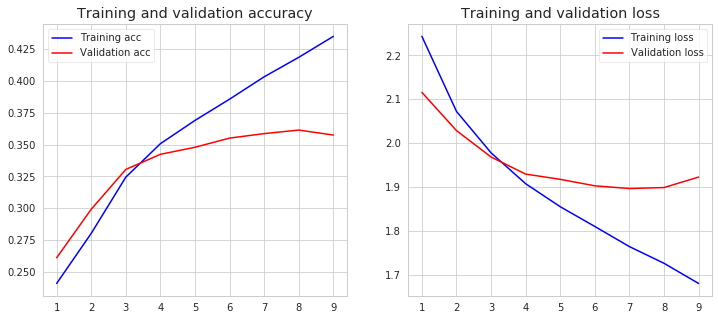

In [0]:
plot_history(history)

#### Tune hyperparameters

As we saw, some layers works better with `big` and some with `tiny` model. Now will propose one deep network that consists all of proposed layers and will try to work out hyperparameters (such as dropout ratio in `Dropout`) that suits it the best. 


In [0]:
embedding_dim = 200
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


def create_model(num_filters, kernel_size, dense_neurons, dropout_ratio):
    with strategy.scope():

        embedding_matrix = external_embeddings['twitter.27B.200d']

        model = keras.Sequential()
        model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix]))
        model.add(keras.layers.Conv1D(num_filters, kernel_size, activation='relu'))
        model.add(keras.layers.GlobalMaxPooling1D())
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(dense_neurons, activation='relu'))
        model.add(keras.layers.Dropout(dropout_ratio))
        model.add(keras.layers.Dense(13, activation='softmax'))
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'],
                    )
        
    return model


def split_to_params(params_dict):
    params_list = list(params_dict.items())
    labels = [label for label,_ in params_list]
    params = [param for _,param in params_list]
    params_product = product(*params)
    return [dict(zip(labels, p)) for p in params_product]


def grid_check(model_creator, params_dict):
    all_params = split_to_params(params_dict)

    print(f'Will check {len(all_params)} combinations')

    results = []
    cnt = 0

    for params in all_params:
        model = model_creator(**params)
        
        history = model.fit(
            X_train, 
            y_train,
            validation_data=(X_test, y_test),
            verbose=False,
            epochs=30,
            batch_size=1000,
            callbacks=[early_stop_callback]
        )

        max_accuracy = max(history.history['val_accuracy'])

        results.append({
            'max_accuracy': max_accuracy, 
            'history': history, 
            'params': params,
            'model': model})
        
        cnt += 1
        print(f'{cnt}/{len(all_params)}')

    return results



In [0]:
param_grid = {
    'num_filters': [128, 512],#, 2048],
    'kernel_size': [3, 5, 7], 
    'dense_neurons': [256, 1024, 1048],
    'dropout_ratio': [0, 0.5]
}
# param_grid = {
#     'num_filters': [100],
#     'kernel_size': [10], 
#     'dense_neurons': [512], 
#     'dropout_ratio': [0]
# }
output_file = 'drive/My Drive/Colab Notebooks/ML_project/search_result2.txt'

results = grid_check(create_model, param_grid)

# print(results)

the_best = max(results, key=lambda x: x['max_accuracy'])

max_accuracy = the_best['max_accuracy']
the_best_params = the_best['params']

# Print results

result = f' Test accuracy: {max_accuracy} \n Params: {the_best_params} \n'
print(result)

with open(output_file, 'w') as f:
    f.write(result)

Will check 36 combinations
1/36
2/36
3/36
4/36
5/36
6/36
7/36
8/36
9/36
10/36
11/36
12/36
13/36
14/36
15/36
16/36
17/36
18/36
19/36
20/36
21/36
22/36
23/36
24/36
25/36
26/36
27/36
28/36
29/36
30/36
31/36
32/36
33/36
34/36
35/36
36/36
 Test accuracy: 0.3823232352733612 
 Params: {'num_filters': 512, 'kernel_size': 3, 'dense_neurons': 1024, 'dropout_ratio': 0.5} 



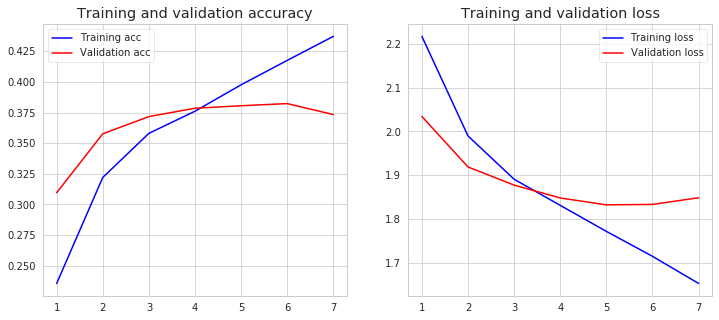

In [0]:
plot_history(the_best['history'])

In [0]:
param_grid = {
    'num_filters': [1024, 2048],
    'kernel_size': [2, 3, 4], 
    'dense_neurons': [1024],
    'dropout_ratio': [0.5]
}
# param_grid = {
#     'num_filters': [100],
#     'kernel_size': [10], 
#     'dense_neurons': [512], 
#     'dropout_ratio': [0]
# }
output_file = 'drive/My Drive/Colab Notebooks/ML_project/search_result3.txt'

results = grid_check(create_model, param_grid)

# print(results)

the_best = max(results, key=lambda x: x['max_accuracy'])

max_accuracy = the_best['max_accuracy']
the_best_params = the_best['params']

# Print results

result = f' Test accuracy: {max_accuracy} \n Params: {the_best_params} \n'
print(result)

with open(output_file, 'w') as f:
    f.write(result)

Will check 6 combinations
1/6
2/6
3/6
4/6
5/6
6/6
 Test accuracy: 0.3839646577835083 
 Params: {'num_filters': 2048, 'kernel_size': 3, 'dense_neurons': 1024, 'dropout_ratio': 0.5} 



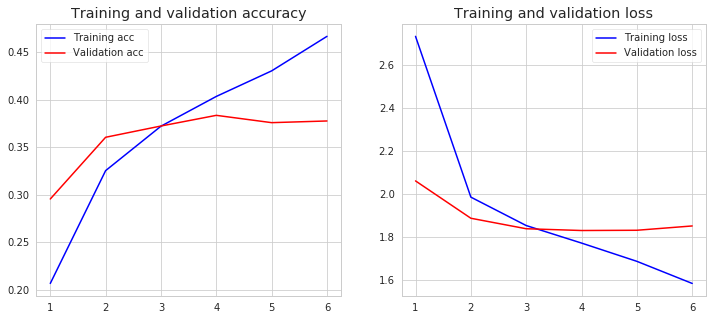

In [0]:
plot_history(the_best['history'])

### Experiments

On the very end we will make one more experiment. We will chain two `Conv1D` layers together. Intuition is that one layer of this type can recognise simply local patterns. Thus second one should recognise patterns in patterns. We will not try to tune parameters for this one.

In [0]:
embedding_dim = 200
early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


with strategy.scope():

    embedding_matrix = external_embeddings['twitter.27B.200d']

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen, trainable=True, weights=[embedding_matrix]))
    model.add(keras.layers.Conv1D(2048, 3, activation='relu'))
    model.add(keras.layers.Conv1D(256, 3, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(13, activation='softmax'))
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'],
                )


In [0]:
history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=1000,
    # callbacks=[early_stop_callback],
    # class_weight=class_weights
)

Train on 31680 samples, validate on 7920 samples
Epoch 1/10
31680/31680 [==============================] - 14s 444us/sample - loss: 2.1718 - accuracy: 0.2414 - val_loss: 1.9964 - val_accuracy: 0.3235
Epoch 2/10
31680/31680 [==============================] - 9s 297us/sample - loss: 1.9775 - accuracy: 0.3274 - val_loss: 1.9103 - val_accuracy: 0.3595
Epoch 3/10
31680/31680 [==============================] - 9s 297us/sample - loss: 1.8968 - accuracy: 0.3583 - val_loss: 1.8861 - val_accuracy: 0.3641
Epoch 4/10
31680/31680 [==============================] - 9s 298us/sample - loss: 1.8185 - accuracy: 0.3837 - val_loss: 1.8709 - val_accuracy: 0.3742
Epoch 5/10
31680/31680 [==============================] - 9s 297us/sample - loss: 1.7543 - accuracy: 0.4079 - val_loss: 1.8679 - val_accuracy: 0.3713
Epoch 6/10
31680/31680 [==============================] - 9s 297us/sample - loss: 1.6660 - accuracy: 0.4338 - val_loss: 1.8903 - val_accuracy: 0.3694
Epoch 7/10
31680/31680 [==========================

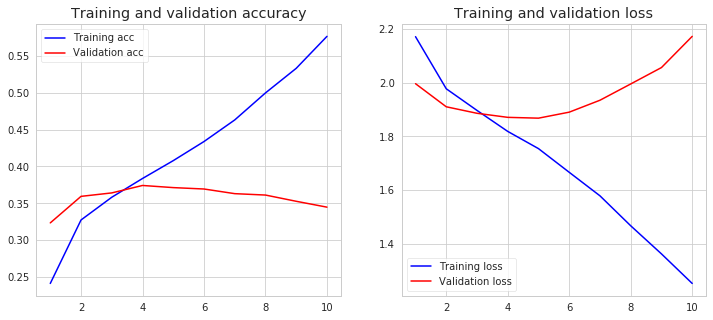

In [0]:
plot_history(history)